In [4]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model, preprocessing
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display
import warnings
import seaborn as sns

In [69]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files])
df_imported.index = pd.DatetimeIndex(df_imported.index, freq='H')
grouped = df_imported.groupby(level=0)
df_imported = grouped.last()
df_imported.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2016-05-17 20:00:00 to 2016-05-25 19:00:00
Freq: H
Data columns (total 25 columns):
$                           192 non-null int64
dateStamp                   32 non-null object
dew_point                   192 non-null float64
modelCode                   32 non-null object
modelRun                    32 non-null float64
periodSchedule              32 non-null float64
pressure                    192 non-null int64
screen_relative_humidity    192 non-null float64
sea_temperature             192 non-null float64
surf_max                    32 non-null float64
surf_min                    32 non-null float64
swell_direction1            32 non-null float64
swell_direction2            32 non-null float64
swell_direction3            32 non-null float64
swell_height1               32 non-null float64
swell_height2               32 non-null float64
swell_height3               32 non-null float64
swell_period1               32 non-

In [59]:
def plot_datetime_series(series, title, xlabel='Time', ylabel='', label=['-', '-', '-', '-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        if type(s.index) is not pd.tseries.index.DatetimeIndex:
            dates = matplotlib.dates.date2num([dateutil.parser.parse(dt) for dt in s.index])
        else:
            dates = s.index
        plt.plot_date(
            dates,
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()

available target values: 32


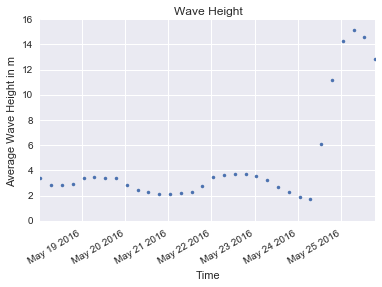

target values after interpolation: 187


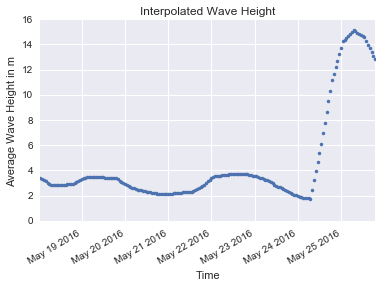

In [72]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', '.')
# fill NAs with linearly interpolated data where explanatory data is present
s_target = s_target.loc[df_imported['wind_speed'].notnull()].interpolate()
#---respective data removed---- there's a big gap which we shouldn't interpolate
#s_target['2016-05-16 14:00:00':'2016-05-18 00:00:00'] = None
#-- uncomment to remove some outliers
#s_target = s_target[:'May 24 2016, 1am']
print('target values after interpolation:', s_target.count())  
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', '.')

In [76]:
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    #print(df_radians.columns)
    #def sine(series):
    #    pd.Series(series.apply(math.sin)
    df_sin = df_radians.apply(lambda series: series.map(math.sin))
    df_cos = df_radians.apply(lambda series: series.map(math.cos))
    df_sin.columns = [col + '-Sin' for col in df_sin.columns]
    df_cos.columns = [col + '-Cos' for col in df_cos.columns]
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            df_sin,
            df_cos
            #directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees-Sin,degrees-Cos
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


In [80]:
# sorted out at this point: 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature'
df_explanatory = df_imported[['wind_direction', 'wind_speed', 'wave_height', 'wave_period', 'pressure']]
df_explanatory = df_explanatory.dropna()
df_explanatory
display(df_explanatory[['wind_direction']].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('becomes')
display(df_explanatory[['wind_direction']].head())
print('becomes')
df_explanatory = degrees_to_sin_cos(df_explanatory, 'wind_direction')
display(df_explanatory[['wind_direction-Sin','wind_direction-Cos']].head())

,wind_direction
2016-05-17 20:00:00,WSW
2016-05-17 21:00:00,WSW
2016-05-17 22:00:00,WSW
2016-05-17 23:00:00,W
2016-05-18 00:00:00,W


becomes


,wind_direction
2016-05-17 20:00:00,247.5
2016-05-17 21:00:00,247.5
2016-05-17 22:00:00,247.5
2016-05-17 23:00:00,270.0
2016-05-18 00:00:00,270.0


becomes


,wind_direction-Sin,wind_direction-Cos
2016-05-17 20:00:00,-0.92388,-3.826834e-01
2016-05-17 21:00:00,-0.92388,-3.826834e-01
2016-05-17 22:00:00,-0.92388,-3.826834e-01
2016-05-17 23:00:00,-1.00000,-1.836970e-16
2016-05-18 00:00:00,-1.00000,-1.836970e-16


In [10]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
int64,wind_speed
float64,wave_height
float64,wave_period
int64,pressure
float64,wind_direction-Sin
float64,wind_direction-Cos


In [11]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_speed            187
wave_height           187
wave_period           187
pressure              187
wind_direction-Sin    187
wind_direction-Cos    187
surf_avg              187
dtype: int64

# Normalization

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_train= df_train.apply(preprocessing.scale)
display(df_train.head())

,wind_speed,wave_height,wave_period,pressure,wind_direction-Sin,wind_direction-Cos,surf_avg
2016-05-18 01:00:00,1.409184,0.155758,-0.753229,-0.295770,-0.81826,1.161437,-0.298420
2016-05-18 02:00:00,0.791082,0.934547,0.698872,-0.483896,-0.91167,0.374710,-0.322407
2016-05-18 03:00:00,0.791082,0.778789,0.698872,-0.483896,-0.81826,1.161437,-0.346394
2016-05-18 04:00:00,0.997116,1.713336,0.698872,-0.483896,-0.81826,1.161437,-0.370381
2016-05-18 05:00:00,0.791082,1.557579,0.698872,-0.483896,-0.81826,1.161437,-0.394368


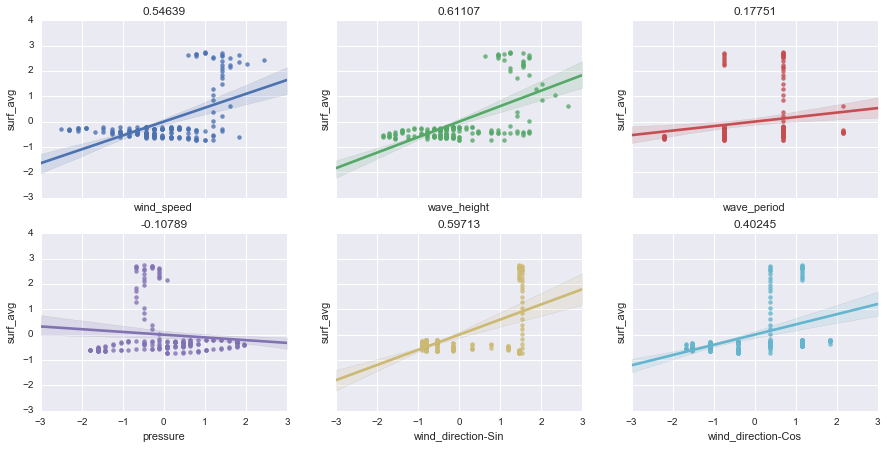

In [45]:
def plot_scatter_correlation(df, target):
    fig, axes = plt.subplots(nrows=math.ceil(len(df.columns)/3), ncols=3, sharex=True, sharey=True, figsize=(15,7))
    for i,variable in enumerate(df.columns):
        row = 0
        col = i
        if i > 2:
            row = 1
            col = i - 3
        correlation = df[variable].corr(target)
        title = "{:.5f}".format(correlation)    #variable + ': ' + "{:.5f}".format(correlation)      
        sns.regplot(df[variable], target, ax=axes[row][col])#, 'o')
        axes[row][col].set_title(title)
        #df.plot.scatter(x=variable, y=target_var, marker='+', ax=axes[row,col], title=title)

plot_scatter_correlation(df_train[df_explanatory.columns], df_train[target_var])

# Cross Correlation

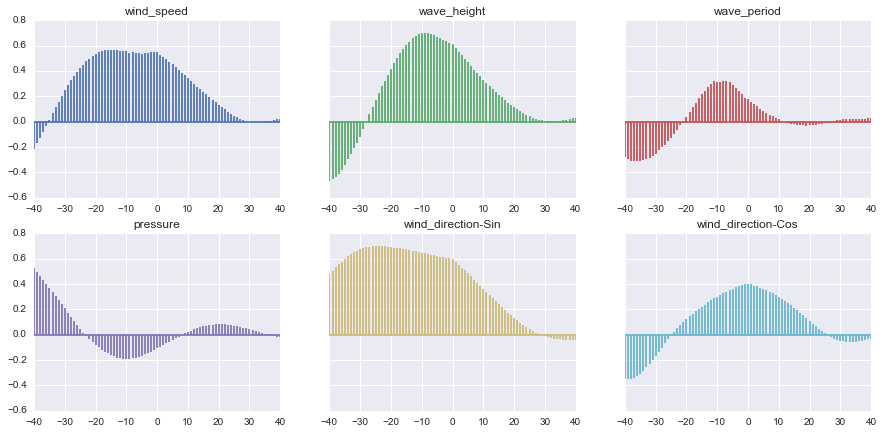

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(7)
for i,var in enumerate(df_explanatory.columns):
    row = 0
    col = i
    if i > 2:
        row = 1
        col = i - 3
    axes[row][col].xcorr(df_train[var], df_train[target_var], maxlags=40, color=sns.color_palette()[i])
    axes[row][col].set_title(var)

The highest correlation seems to be at a lag of about -5, but is different for each variable. 
- Wind speed appears to have a very high lag, just like the wind direction.
- Wave height and wave period both have a lag around 5.

,unlagged,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10
wind_speed,0.546395,0.567997,0.575363,0.583999,0.592786,0.598619,0.611043
wave_height,0.611074,0.692191,0.707142,0.721591,0.729601,0.733738,0.733915
wave_period,0.177510,0.292799,0.312596,0.328609,0.324523,0.316814,0.321828
pressure,-0.107892,-0.164807,-0.173461,-0.180846,-0.186706,-0.189077,-0.190119
wind_direction-Sin,0.597132,0.641160,0.650973,0.661191,0.671889,0.683017,0.694517
wind_direction-Cos,0.402448,0.370346,0.361046,0.350759,0.339016,0.326331,0.312442


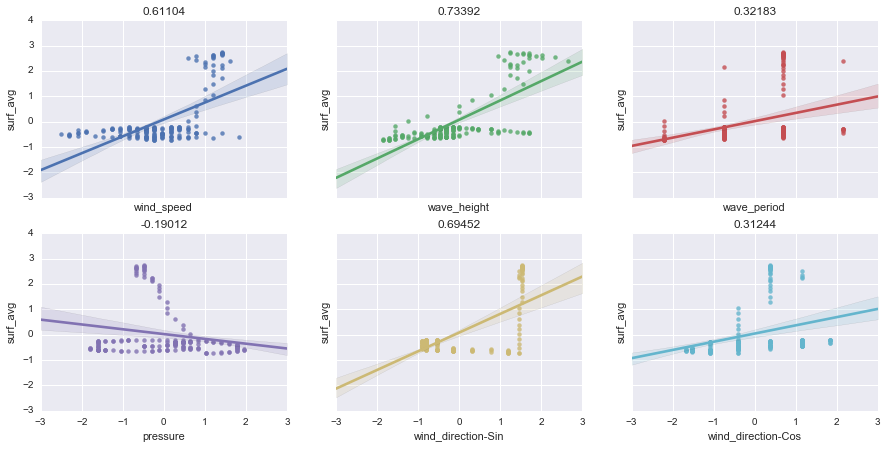

In [40]:
lag_compare = pd.DataFrame(
    {'unlagged': [df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
for lag in range(5,11):
    lag_compare['lag '+str(lag)] = [df_train[target_var].shift(-1 * lag).corr(df_train[column]) for column in df_explanatory.columns] 
display(lag_compare)

df_lagged = df_train.copy()
df_lagged[target_var] = df_lagged[target_var].shift(-10)
plot_scatter_correlation(df_lagged[df_explanatory.columns], df_lagged[target_var])

In [16]:
corr_with_target = pd.DataFrame(
    {'no ewma': [df_lagged[column].corr(df_lagged[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,10):
    corr_with_target['ewma '+str(span)] = pd.Series([ pd.ewma(df_lagged[column], span=span).corr(df_lagged[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
corr_with_target
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,no ewma,ewma 2,ewma 3,ewma 4,ewma 5,ewma 6,ewma 7,ewma 8,ewma 9
wind_speed,0.611043,0.631803,0.643759,0.653757,0.662830,0.671115,0.678539,0.684996,0.690401
wave_height,0.733915,0.740188,0.739437,0.735696,0.729894,0.722448,0.713617,0.703598,0.692562
wave_period,0.321828,0.348468,0.354730,0.353238,0.347604,0.339321,0.329171,0.317654,0.305136
pressure,-0.190119,-0.189377,-0.187426,-0.184457,-0.180589,-0.175877,-0.170356,-0.164063,-0.157044
wind_direction-Sin,0.694517,0.704325,0.712931,0.721361,0.729805,0.738274,0.746720,0.755076,0.763271
wind_direction-Cos,0.312442,0.313909,0.310026,0.304479,0.298022,0.290830,0.282952,0.274434,0.265348


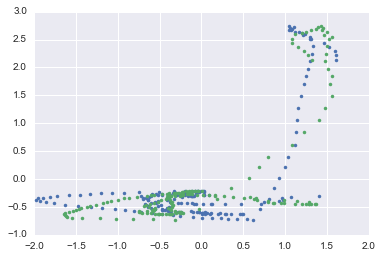

In [58]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], '.', color=sns.color_palette()[0])
plt.plot(pd.ewma(df_train['wave_height'], span=12), df_train[target_var], '.', color=sns.color_palette()[1])

In [18]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [-0.00745262  0.22728123 -0.01741297 -0.06236833  0.55140727  0.29463762]


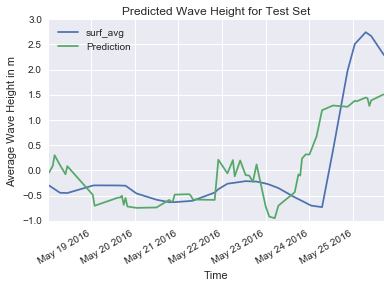

In [81]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m')

coefficients:  [-0.07978612  0.46786344  0.08143575 -0.11852746  0.73291372  0.15187084]
intercept:  0.116440524835


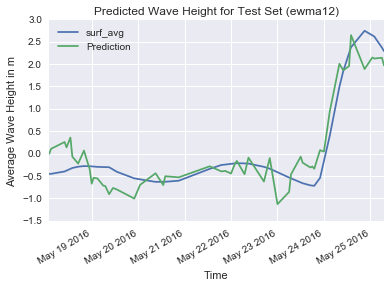

In [60]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
#df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_lagged.dropna(), 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set (ewma12)', 'Time', 'Average Wave Height in m')

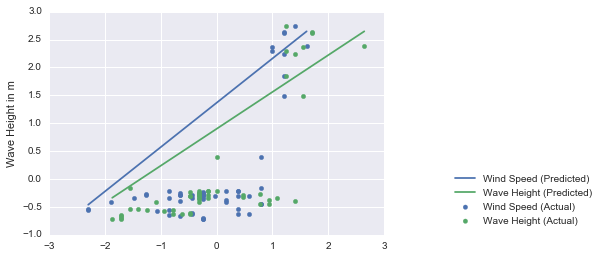

In [63]:
plt.scatter(
    test_set['wind_speed'],
    test_set[target_var],
    color=sns.color_palette()[0]
)
plt.scatter(
    test_set['wave_height'],
    test_set[target_var],
    color=sns.color_palette()[1]
)

predictions_wind_speed = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wind_speed'], name='Prediction').sort_index()
predictions_wave_height = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wave_height'], name='Prediction').sort_index()

plt.plot([test_set['wind_speed'].min(), test_set['wind_speed'].max()], [predictions_wind_speed.iloc[0], predictions_wind_speed.iloc[-1]])
plt.plot([test_set['wave_height'].min(), test_set['wave_height'].max()], [predictions_wave_height.iloc[0], predictions_wave_height.iloc[-1]])
plt.legend(['Wind Speed (Predicted)', 'Wave Height (Predicted)', 'Wind Speed (Actual)', 'Wave Height (Actual)'], bbox_to_anchor=(1.65, 0), loc='lower right')
plt.ylabel('Wave Height in m')

In [22]:
lm = sm.OLS(train_set[target_var], train_set[df_explanatory.columns]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     120.2
Date:                Thu, 26 May 2016   Prob (F-statistic):           7.29e-48
Time:                        16:31:57   Log-Likelihood:                -51.870
No. Observations:                 124   AIC:                             115.7
Df Residuals:                     118   BIC:                             132.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
wind_speed            -0.1392      0.068     -2.053      0.042        -0.274    -0.005
wave_height            0.6017      0.075      7.990      0.000         0.453     0.751
wave_period            0.0033      0.052      0.063      0.949        -0.099     0.105
pressure              -0.1115      0.044     -2.544      0.012        -0.198    -0.025
wind_direction-Sin     0.6411      0.050     12.702      0.000         0.541     0.741
wind_direction-Cos     0.1063      0.048      2.215      0.029         0.011     0.201
==============================================================================
Omnibus:                        4.343   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                5.342
Skew:                          -0.111   Prob(JB):                       0.0692
Kurtosis:                       3.992   Cond. No.                         4.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R² value indicates the percentage of variance in the data which are explained by the model. This is a good fit, but also may indicate overfit.

In [23]:
print('p value >= 0.5')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.5')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.5
wave_period    0.949491
dtype: float64

p value < 0.5
wind_speed            4.226993e-02
wave_height           1.013476e-12
pressure              1.225652e-02
wind_direction-Sin    7.969945e-24
wind_direction-Cos    2.868347e-02
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.